<a href="https://colab.research.google.com/github/ispapadakis/nlp/blob/master/NLP_Sentiment_Analysis_Using_Modified_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Sentiment Analysis Using BERT-Fine-Tuning

**FEATURES**

- Uses Tensorflow 2
- Applied to New Dataset: Quora Insincere Questions Classification

- Based on https://www.tensorflow.org/tutorials/text/classify_text_with_bert

- With model optimization

**Modeling Strategy**

- Use one of the many Bert models available on Tensorflow.
- Add fully connected layers on top
- Fit the resulting model to the data at hand

# Install & Load Packages

In [1]:
# @title Install Libraries
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 9.7MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 10.0MB/s 
     |████████████████████████████████| 1.2MB 34.1MB/s 
     |████████████████████████████████| 358kB 38.6MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 645kB 40.4MB/s 
     |████████████████████████████████| 174kB 43.4MB/s 
     |████████████████████████████████| 706kB 24.4MB/s 
     |████████████████████████████████| 37.6MB 77kB/s 
     |████████████████████████████████| 51kB 5.0MB/s 


In [3]:
# @title Load Packages

import os
import shutil
from itertools import product

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

tf.get_logger().setLevel('ERROR')

In [4]:
max_seq_length = 70

# Load Data

Obtain Dataset from Quora Insincere Questions Classification Competition

The data consists of short questions from Quora, that are labeled as sincere (0) or insincere (1). It is reasonably large to capture the needs for a real-life application. Out of necessity and to demonstrate the capability we begin with data broken down to smaller files (in .csv form). Our model is fit using Tensorflow generators. This way we limit the amount of memory needed for a) model fitting and b) scoring.

In [5]:
!git clone https://github.com/ispapadakis/nlp -q

In [6]:
!unzip -jq /content/nlp/quora_test.zip -d quora_test

In [7]:
!unzip -jq /content/nlp/quora_train_1.zip -d quora_train
!unzip -jq /content/nlp/quora_train_2.zip -d quora_train
!unzip -jq /content/nlp/quora_train_3.zip -d quora_train

In [8]:
!ls quora_train

part_10.csv  part_16.csv  part_21.csv  part_27.csv  part_32.csv  part_7.csv
part_11.csv  part_17.csv  part_22.csv  part_28.csv  part_33.csv  part_8.csv
part_12.csv  part_18.csv  part_23.csv  part_29.csv  part_3.csv	 part_9.csv
part_13.csv  part_19.csv  part_24.csv  part_2.csv   part_4.csv
part_14.csv  part_1.csv   part_25.csv  part_30.csv  part_5.csv
part_15.csv  part_20.csv  part_26.csv  part_31.csv  part_6.csv


In [9]:
!rm -R nlp

In [10]:
df = pd.read_csv("quora_train/part_1.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39998 entries, 0 to 39997
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   qid            39998 non-null  object
 1   question_text  39998 non-null  object
 2   target         39998 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [11]:
df.groupby(df.target).head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [12]:
df.question_text[0], df.target[0], df.target.mean()

('How did Quebec nationalists see their province as a nation in the 1960s?',
 0,
 0.06190309515475774)

In [13]:
import gc
del df
gc.collect()

112

In [14]:
%%time

# @title Build Keras-Friendly Data Structure

dir_structure = [['quora'],['train','validation'],['sincere','insincere']]

for p in product(*dir_structure):
  dname = "/".join(p)
  if not os.path.isdir(dname): os.makedirs(dname)

labeler = lambda x: 'insincere' if x == 1 else 'sincere'

def store_text_in_keras_friendly_way(dfdir='quora_train',pathname='quora',validation_ratio=0.5):
  for fname in os.listdir(dfdir):
    df = pd.read_csv( dfdir + "/" + fname)
    df['sample'] = ['validation' if x < validation_ratio else 'train' 
                    for x in np.random.rand(len(df)) > validation_ratio]
    for _, tname, txt, lbl, smp in df.itertuples():
      path = pathname + "/" + smp + "/" + labeler(lbl) + "/" + tname + ".txt"
      with open(path,'w') as f:
        print(txt,file=f)

store_text_in_keras_friendly_way()

CPU times: user 46.3 s, sys: 1min 4s, total: 1min 51s
Wall time: 2min 34s


In [15]:
!rm -R quora_train

In [16]:
!cat quora/train/insincere/000e67648fce55f011be.txt

cat: quora/train/insincere/000e67648fce55f011be.txt: No such file or directory


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
steps_per_epoch_max = 200

train_ds = tf.keras.preprocessing.text_dataset_from_directory('quora/train',batch_size=batch_size, max_length=max_seq_length)
valid_ds = tf.keras.preprocessing.text_dataset_from_directory('quora/validation',batch_size=batch_size, max_length=max_seq_length)

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 654075 files belonging to 2 classes.
Found 652047 files belonging to 2 classes.


In [18]:
class_names = train_ds.class_names

In [19]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'Why does the women say bye sweety?\n'
Label : 1 (sincere)
Review: b'Why should I continue living just to make others happy?\n'
Label : 1 (sincere)
Review: b'Does the name of the lakes in Slavic languages are only neutral?\n'
Label : 1 (sincere)


In [20]:
train_ds = configure_dataset( train_ds.take(7000) )
valid_ds = configure_dataset( valid_ds.take(500) )

Reducing the size of the training sample to match the computational resources available.

# Build Sentiment Analysis Model

## BERT Model

First Obtain a Pretrained Bert Model

*Code Below Hidden*

In [21]:
# @title Select BERT Model

bert_model_name = 'electra_small'

In [22]:
#@title
# All Available Models
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

# All Available Preprocessing Models
map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [23]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [24]:
text_test = ['What is the chemical composition of blue vodka shots?']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2054  2003  1996  5072  5512  1997  2630 21092  7171  1029   102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [26]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/electra_small/2
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[ 0.31410167  0.49924517 -0.5990788   0.34853178  0.64439017 -0.10572165
  0.7990648   0.9029216   0.35139617 -0.2815125   0.03656875 -0.90336865]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[ 0.3250896   0.5483002  -0.691709   ...  1.1065531  -0.95653176
   0.21341462]
 [ 0.54310805  0.00960368 -0.5540462  ...  0.3237872  -0.05437493
   0.39742643]
 [-0.18921308 -0.0195659   1.2086744  ...  0.73125625 -2.0373333
   0.9947276 ]
 ...
 [ 0.02106191  0.56318474  0.02782773 ...  0.18746285  0.4464738
   0.33136106]
 [-0.66326946 -0.12063389  0.31808412 ...  0.36141562 -1.0250047
   0.7239211 ]
 [ 0.32615605  0.5515342  -0.69055355 ...  1.1058574  -0.9561197
   0.21560813]]


## Transform Bert Model to Better Fit Data at Hand

In [27]:
# @title Build New Model Based on Bert

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  # New Layers
  net = tf.keras.layers.Dropout(0.1)(net)
  # Final Layer for Classification
  net = tf.keras.layers.Dense(1, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [28]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.38319296]], shape=(1, 1), dtype=float32)


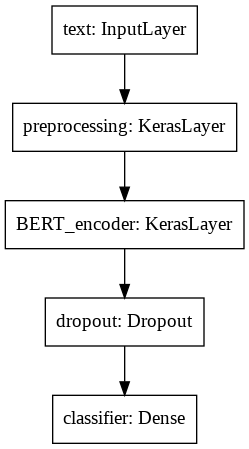

In [29]:
tf.keras.utils.plot_model(classifier_model)

In [30]:
# @title Fit Parameters
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 4
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
steps_per_epoch = min(steps_per_epoch, 1500)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 0.1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics,
                         )

Fit to Training Dataset

In [31]:
# @title Fit Model to Data at Hand
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x=train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
    )

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/4
1500/1500 [==============================] - 924s 602ms/step - loss: 0.2938 - binary_accuracy: 0.8099 - val_loss: 0.1440 - val_binary_accuracy: 0.9481
Epoch 2/4
1500/1500 [==============================] - 888s 592ms/step - loss: 0.1405 - binary_accuracy: 0.9461 - val_loss: 0.1372 - val_binary_accuracy: 0.9409
Epoch 3/4
1500/1500 [==============================] - 880s 587ms/step - loss: 0.1344 - binary_accuracy: 0.9494 - val_loss: 0.1302 - val_binary_accuracy: 0.9476
Epoch 4/4
1500/1500 [==============================] - 882s 588ms/step - loss: 0.1319 - binary_accuracy: 0.9495 - val_loss: 0.1317 - val_binary_accuracy: 0.9485


Notable Best Fits

<pre>

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
7000/7000 [==============================] - 597s 85ms/step - loss: 0.2329 - binary_accuracy: 0.8834

val_loss: 0.1264 - val_binary_accuracy: 0.9495
</pre>

small-bert has better performance


In [32]:
y_true = list(valid_ds.unbatch().map(lambda x, y: y).as_numpy_iterator())

In [33]:
predictions = classifier_model.predict(valid_ds)

In [34]:
print(classification_report( y_true, predictions.flatten() > 0,  target_names = class_names ))

              precision    recall  f1-score   support

   insincere       0.62      0.48      0.54       969
     sincere       0.97      0.98      0.97     15031

    accuracy                           0.95     16000
   macro avg       0.79      0.73      0.76     16000
weighted avg       0.95      0.95      0.95     16000



In [35]:
pd.DataFrame(history.history).style.background_gradient()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.202487,0.908000,0.143953,0.948062
1,0.138884,0.946625,0.137202,0.940938
2,0.135649,0.947812,0.130161,0.947563
3,0.130485,0.950500,0.131711,0.948500


In [36]:
# @title Save Fitted Model

dataset_name = 'qiqc'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

# Apply Saved Model to New Data

In [37]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [39]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {1-results[i][0]:.2%}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


df = pd.read_csv("quora_test/part_1.csv", nrows=30)
examples = df.question_text.values

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: My voice range is A2-C5. My chest voice goes up to F4. Included sample in my higher chest range. What is my voice type? : score: 0.12%
input: How much does a tutor earn in Bangalore? : score: 0.07%
input: What are the best made pocket knives under $200-300? : score: 0.10%
input: Why would they add a hypothetical scenario that’s impossible to happen in the link below? It shows what 800 meters rise in sea level would look like. : score: 0.84%
input: What is the dresscode for Techmahindra freshers? : score: 0.12%
input: How well are you adapting to the Trump era? : score: 1.65%
input: What should be the last thing people do in life? : score: 0.12%
input: Received conditional offer for Masters in International Business from UNSW, Monash and Macquarie. Which one should I choose? : score: 0.20%
input: What does appareils photo mean in French? : score: 0.09%
input: Is there a system of Public Interest Litigation (PIL) in Canada? : score: 0.32%
input: What'